In [561]:
## import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as sci
import sympy as sy
from sklearn.metrics import r2_score

In [562]:
import os 
input1='/Users/HP/Documents/하이웍스 받은파일/data/env'
# os.listdir(input1)
S20env=pd.read_csv('env/CT_20S.csv', usecols=[0,1,3,4])#['Pyrano_Wsec_1','Temp_Avg','Humid_Avg'])
S21env=pd.read_csv('env/CT_21S.csv', usecols=[0,2,3,4])#['Pyrano_Wsec_2','Temp_Avg','Humid_Avg'])
W20env=pd.read_csv('env/CT_20W.csv', usecols=[0,1,3,4])#['Pyrano_Wsec_1','Temp_Avg','Humid_Avg']) # 온습도 데이터 이상 
W21env=pd.read_csv('env/CT_21W.csv', usecols=[0,2,3,4])#['Pyrano_Wsec_2','Temp_Avg','Humid_Avg'])

# W20env.plot(subplots=True)
S20env

,date,Pyrano_Wsec_1,Temp_Avg,Humid_Avg
0,2020-02-26 00:00:00,0.0,23.29500,47.0725
1,2020-02-26 00:10:00,0.0,24.00125,44.2900
2,2020-02-26 00:20:00,0.0,23.63250,44.2975
3,2020-02-26 00:30:00,0.0,23.10250,44.7500
4,2020-02-26 00:40:00,0.0,22.49000,45.6325
...,...,...,...,...
19147,2020-07-07 23:10:00,0.0,25.01000,81.7525
19148,2020-07-07 23:20:00,0.0,24.91625,81.9125
19149,2020-07-07 23:30:00,0.0,24.80125,82.1650
19150,2020-07-07 23:40:00,0.0,24.72125,82.4050


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

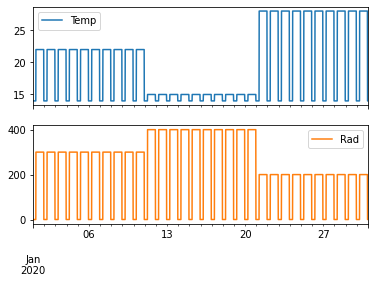

In [563]:
time_period=6*24*30
time=pd.date_range('2020-01-01 0:0:0',periods=time_period, freq="10T")
df= pd.DataFrame(None, index = time)

DOY=df.index.strftime('%j').astype(int)

sunrise = 6
sunset = 22
df['day_night'] = df.index.hour.map(lambda h: 'day' if sunrise <= h <= sunset else 'night' )

df.loc[(df['day_night'] == 'day') , 'Temp'] = 22
df.loc[(df['day_night'] == 'night') , 'Temp'] = 14
df.loc[(df['day_night'] == 'day') & ((DOY  <= 20) &(DOY >10)), 'Temp'] = 15
df.loc[(df['day_night'] == 'day') & (20< DOY ), 'Temp'] = 28

df.loc[(df['day_night'] == 'day') & (DOY <= 10), 'Rad'] = 300
df.loc[(df['day_night'] == 'day') & ((DOY  <= 20) &(DOY >10)), 'Rad'] = 400
df.loc[(df['day_night'] == 'day') & (20< DOY ), 'Rad'] = 200
df= df.fillna(0)

# mask = (df.index.between(pd.Timedelta('08:00:00'), pd.Timedelta('18:00:00')))
# DatetimeIndex.indexer_between_time(start_time, end_time, include_start=True, include_end=True)[source]
# df1=df[mask]
# df2=df[~mask]

df.plot(subplots=True) #.iloc[:24*6*5,:]


In [564]:
'''
main code 
'''

#Model 1 
comp_20 = 7.32*10**(-5)
Q_10 = 2
CO2 = 400
LUE_CO2= 17*10**(-9)
con_bnd= 0.004
con_stem= 0.007
k = 0.7
Q10_resp = 2
C_resp = 3.47*10**(-7)
# W_dry = 0.2 #structure dry weight; kgDM
C_bet= 0.8 # Conversion rate from assimilate to dry matter
C_alp= 0.68 # conversion factor from carbon dioxide into sugar equivalents 


#Model 2 
con_gro = 5*10**(-6)
Q10_gro =1.6
W_str =  0.2 #structure dry weight; kgDM
W_nsc = 0.8

df=df.resample('1H').mean()
DAT=np.arange(0,len(df.resample('1D')))
DOY=df.index.strftime('%j').astype(int)
LAI =  4/(1+np.exp((20-DOY) /7))
LAI_series = pd.Series(LAI,df.index)
drymass1=[]
drymass2=[]
temp = df.Temp
rad = df.Rad

# Loop over each day in the data
for day in df.index.day.unique():
    # Loop over each hour of the day
    for hour in df.index.hour.unique():
        # Get the hourly value of LAI, temperature and radiation
        LAI_h = LAI_series[(LAI_series.index.day==day) & (LAI_series.index.hour==hour)].values[0]
        temp_h = df[(temp.index.day==day) & (temp.index.hour==hour)].Temp.values[0]
        rad_h = df[(rad.index.day==day) & (rad.index.hour==hour)].Rad.values[0]
        
        # Define parameters using hourly variables
        con_car = -1.32*10**(-5)*temp_h**2 +  5.94*10**(-4)* temp_h  -2.64*10**(-3)
        con_can=1/(1/con_bnd +1/con_stem + 1/con_car) 
        comp = comp_20*Q_10**((temp_h-20)/10)
        LUE= LUE_CO2*((CO2-comp)/(CO2+2*comp))
        phot_max = LUE*rad_h*con_can*(CO2-comp)/(LUE*rad_h+con_can*(CO2-comp)) # maximum assimilation rate (gC/day/m2)
        
        r_gro= con_gro*(W_nsc/(  W_str))*Q10_gro**((temp_h-20)/10)
        
        
        
        # print(day,hour,r_gro,'temp',temp_h, 'rad',rad_h)  
        
        # Calculate the hourly photosynthesis and respiration
        phot = phot_max*(1-np.exp(-k*LAI_h)) # assimilate production (sugar equivalents)
        
        # resp = C_resp*W_dry*Q10_resp**((temp_h-25)/10) # respiration rate (kgC/hr)
        main_resp = C_resp*W_str*Q10_resp**((temp_h-25)/10) # respiration rate (kgC/hr)
        str_gro = r_gro*W_str
        gro_resp= (1-C_bet)*str_gro/C_bet
        
        dX_sol = a1+p1*phot-str_gro-(1-a2)*resp-gro_resp
        
        dW_dt = C_bet*(C_alp*phot - main_resp) # rate of change of dry matter (kgDM/hr)
        
        dW_nsc_dt = C_alp*phot - main_resp - str_gro - gro_resp  # rate of change of dry matter (kgDM/hr)
        dW_str_dt = str_gro
        
        W_nsc = + dW_nsc_dt
        W_str = + dW_str_dt
        
        W_dry1 = + dW_dt
        W_dry2 = +  W_nsc + W_str
      
        drymass1.append(W_dry1*1000)
        drymass2.append(W_dry2*1000)
        

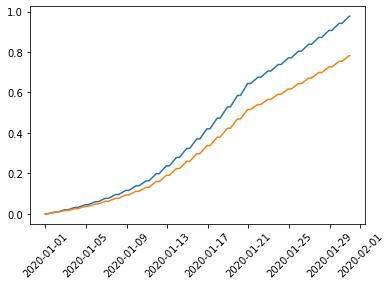

In [559]:
'''
Code plotting
'''
plt.plot(pd.Series(np.cumsum(drymass2),df.index))
plt.plot(pd.Series(np.cumsum(drymass1),df.index))
plt.xticks(rotation=45)
plt.show()